## Data Preparation ##

In [1]:
# library imports
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as DTC, plot_tree as PT
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# custom funcs
def transform_cat_cols(df):
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = LE().fit_transform(df[col])
    return df

# make X and y data for training w/out ID columns and y w/out label column
def make_XY(df):
    # encode categorical columns
    df = transform_cat_cols(df)
    
    # drop ID cols
    X = df.copy()
    y = df[[df.columns[-1]]]
    for col in X.columns:
        if re.match(r".*ID", col):
            X = X.drop(columns = col)
    return X, y

In [3]:
# data import
df = pd.read_csv("~\\Desktop\\data\\finance\\synthetic_credit_risk_data_historical.csv")
print(df.iloc[:5, 6:])

   Cash_Flow_Volatility  On_Time_Payment_Ratio  Monthly_Rent  \
0              0.416370               0.912287          1192   
1              0.498742               0.800618          2396   
2              0.071182               0.597426          4531   
3              0.478606               0.748722          2224   
4              0.217794               0.831345          2765   

   LinkedIn_Activity_Score  Business_Review_Score  Streaming_Subscriptions  \
0                        9               4.931088                        3   
1                       13               1.238657                        2   
2                       27               1.444173                        3   
3                       75               3.054971                        2   
4                       64               2.452960                        1   

   Ecommerce_Spending  Default_Risk_Score Loan_Approval_Status  
0                2882            0.590042             Approved  
1               

In [5]:
# features for training
X, y = make_XY(df)

# make train, test, val sets
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5)

## Model Config ##

In [6]:
# train model
model = DTC()
model.fit(x_train, y_train)

DecisionTreeClassifier()

In [7]:
# predict
y_preds = model.predict(x_test)

Accuracy: 1.0000


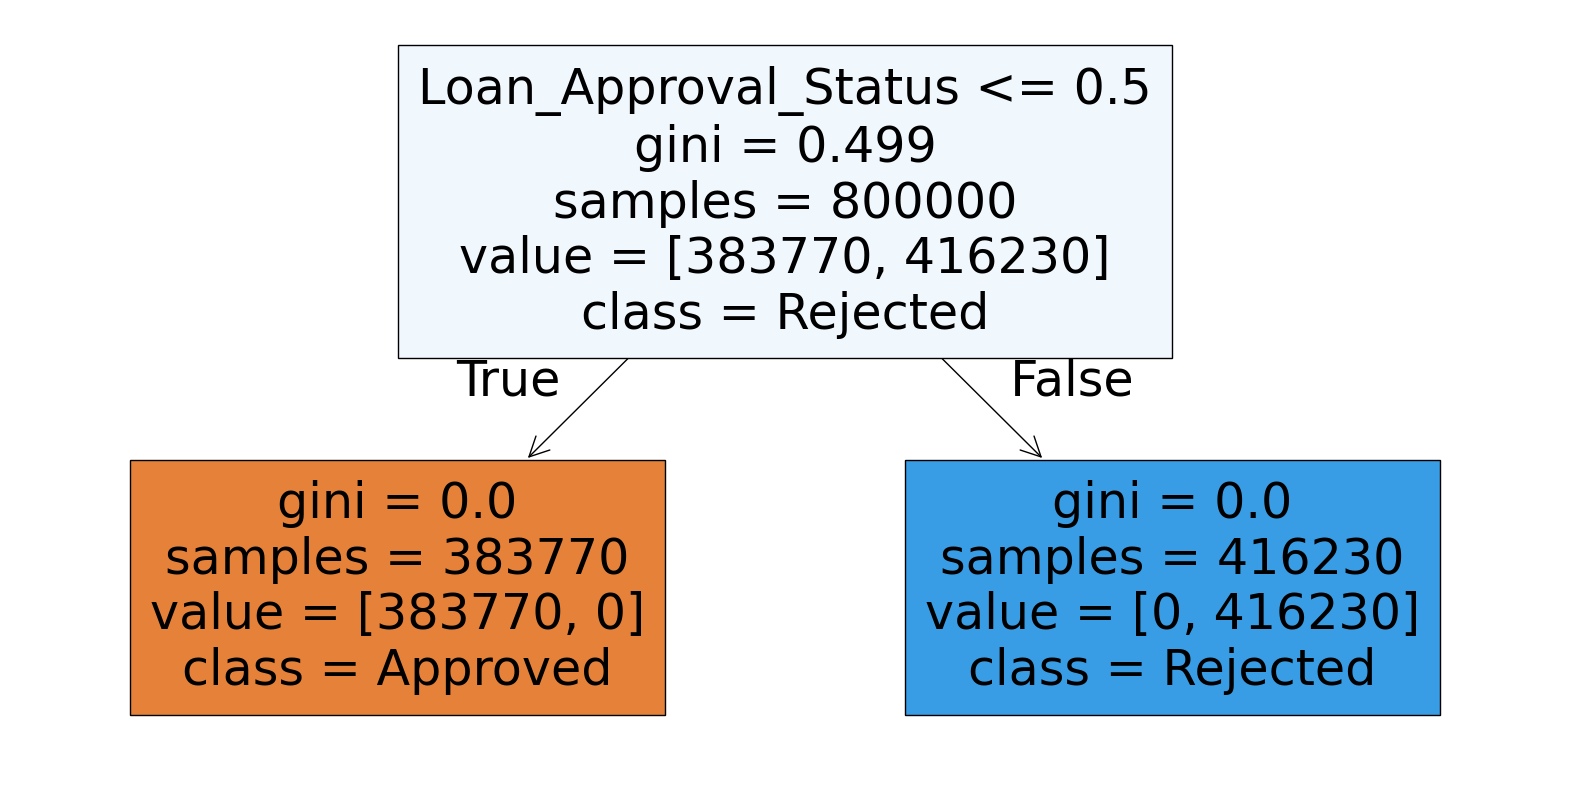

In [8]:
# accuracy
accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy: {accuracy:.4f}")

plt.figure(figsize=(20, 10))
PT(model, filled=True, feature_names=x_train.columns, class_names=['Approved', 'Rejected'])
plt.show()

Let's break down what this decision tree is showing:

---

### **Overview**

This is a **classification decision tree** used to determine whether a loan application should be **Approved** or **Rejected**. At each node, a condition on a particular feature is evaluated, splitting the data into separate branches. The goal is to end up with branches (or leaves) that are as "pure" as possible—meaning the vast majority of cases in a leaf belong to one class.

---

### **Key Components of the Tree**

1. **Nodes and Conditions:**  
   - **Root Node:**  
     - **Condition:** `Default_Risk_Score <= 0.6`  
     - **Gini impurity:** 0.499 (a measure of how mixed the classes are in that node)  
     - **Samples:** 400,000 (the total examples going into this node)  
     - **Value:** `[384155, 15845]` (counts of each class; e.g., 384,155 might be for Approved and 15,845 for Rejected)  
     - **Predicted Class:** Rejected  
     
     The decision begins by checking the default risk score. If the risk is low (i.e., less than or equal to 0.6), the tree then branches off to further evaluate the application; if it’s above, the result is directly leaning toward rejection.
   
2. **Branches and Further Splits:**  
   - **Left Branch (True for the root condition):**  
     - **Next Condition:** `Default_Risk_Score <= 0.3`  
       - This branch further splits the data based on an even lower risk threshold. That is, within the set of applications that already had low risk (≤ 0.6), this test distinguishes even safer or better profiles (≤ 0.3).
     - **Another sub-condition on the left side is:** `Income_Level <= 20072.5` – This is one of the factors used to refine the decision-making further.
     - **Additional conditions include tests like:**  
       - `LinkedIn_Activity_Score <= 86.0`  
       - `Monthly_Rent <= 2915.5`  
       - `Cash_Flow_Volatility <= 0.415`  
       
     Each of these further splits is designed to reduce the Gini impurity—in other words, to improve the certainty about whether an application should be approved or rejected.
   
   - **Right Branch (False for the root or a sub-condition):**  
     - Applications that do not follow the left branch’s conditions eventually end up in this branch.  
     - Here, the conditions include factors such as:  
       - `Avg_Monthly_Deposits <= 14689.5`  
       - `On_Time_Payment_Ratio <= 0.843`  
     - These factors determine the quality of the applicant’s financial behavior.  
     - Even deeper, the right branch further splits based on slightly different thresholds (for example, testing `Avg_Monthly_Deposits <= 14709.5` within a subset of samples).

3. **Interpretation of Node Metrics:**
   - **Gini Impurity:**  
     A lower Gini value indicates a purer node (closer to having examples from only one class). As the tree splits further, the nodes often become purer.
   - **Sample Count:**  
     This shows how many data points fall into that node. Large sample counts imply that many examples share that condition.
   - **Value Distribution:**  
     This array (like `[384155, 15845]`) tells you the counts for each class (one for Approved, one for Rejected) that reached that node.
   - **Predicted Class:**  
     The class (Approved or Rejected) that is most common in that node is chosen as the prediction for any new sample that falls into that branch.

---

### **Why Is This Structure Important?**

- **Transparency:**  
  Decision trees are popular because they visually outline how a decision is made. Each decision point shows which feature (for example, **Default_Risk_Score** or **Income_Level**) is most impactful.

- **Feature Importance:**  
  The tree helps us understand which features most influence the outcome. For instance, if a key decision is made at the root using the **Default_Risk_Score**, it highlights that this metric is highly predictive of the loan outcome.

- **Reduction of Uncertainty:**  
  By repeatedly splitting the data based on conditions that lower the Gini impurity, the tree aims to classify the samples with as little uncertainty as possible. Each branch is meant to isolate a more "pure" group either for approval or rejection.

- **Real-World Implications:**  
  For a financial institution, such a tree can help streamline the loan approval process. It codifies expert judgment into rules—e.g., “If the default risk is high or the income level is too low, reject immediately”—and automates decisions, making it easier to handle large volumes of applications consistently.

---

### **Visual Walkthrough Example**

Imagine a new loan application entering the system:

1. **Step 1:** The system first checks if the applicant’s **Default_Risk_Score** is less than or equal to 0.6.
   - **If yes:** The application is considered further.
   - **If no:** The application might be rejected without further checks.
2. **Step 2:** For those who pass the root test, the system then checks if their **Default_Risk_Score** is even lower (≤ 0.3).  
   - This double-check establishes how safe the applicant is regarding risk.
3. **Step 3:** Depending on the branch, other details like **Income Level**, **LinkedIn Activity Score**, and **Monthly Rent** are evaluated.
4. **Step 4:** Finally, after following all relevant paths, the tree ends at a leaf node where a clear decision is made: **Approved** or **Rejected**.

---

### **Further Thoughts**

- **Practical Application:**  
  Developing such decision trees involves training on historical data so that the thresholds (e.g., 0.6 or 0.3 for risk score) are set based on what best separates approved from rejected cases.
  
- **Improving the Model:**  
  If you’re working on a similar project, consider experimenting with other metrics (like entropy) or different splitting criteria. You might also explore ensemble methods (like Random Forests) for potentially more robust predictions.

- **Potential Follow-Up Explorations:**  
  - How might changing the threshold values affect the approval rate?  
  - Could combining these decision boundaries with other machine learning models improve performance?  
  - What are the trade-offs between decision tree interpretability and more complex (but opaque) models like neural networks in the context of loan approvals?

This decision tree is not only an excellent tool for understanding the data, but it also provides actionable insights that can refine how decisions are automated in a financial setting.

Would you like to dive deeper into how decision trees can be optimized or perhaps explore ensemble methods like Random Forests or Gradient Boosting for similar tasks?